In [20]:
import pandas as pd
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.metrics import classification_report
from sklearn.cluster import OPTICS, cluster_optics_dbscan

In [4]:
incidents = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv")
incidents = incidents.dropna()
incidents.head()

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\IPython\core\interactiveshell.py:3072: DtypeWarning: Columns (2) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime
0,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30
1,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05
2,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18
3,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00
4,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23


In [5]:
incidents.dtypes

publicAddress     object
caseNumber        object
precinct          object
offense           object
description       object
ucrCode          float64
lat              float64
lon              float64
neighborhood      object
incidentDate      object
incidentTime      object
dtype: object

In [6]:
incidents.index = pd.DatetimeIndex(incidents.incidentDate)

incidents['month'] = incidents.index.month
incidents['year'] = incidents.index.year
incidents['dayOfWeek'] = incidents.index.dayofweek
incidents['dayOfMonth'] = incidents.index.day
incidents['dayOfYear'] = incidents.index.dayofyear
incidents['weekOfMonth'] = incidents.dayOfMonth.apply(lambda d: (d-1) // 7 +1)

dayOfYear = list(incidents.index.dayofyear)
weekOfYear = [math.ceil(i/7) for i in dayOfYear]
incidents['weekOfYear'] = weekOfYear

incidents

,publicAddress,caseNumber,precinct,offense,description,ucrCode,lat,lon,neighborhood,incidentDate,incidentTime,month,year,dayOfWeek,dayOfMonth,dayOfYear,weekOfMonth,weekOfYear
incidentDate,,,,,,,,,,,,,,,,,,
2010-01-01,0056Xx Lyndale Av S,MP2010000051,5,CSCR,Crim Sex Cond-Rape,3.0,44.900291,-93.288239,Windom,2010/01/01,00:30,1,2010,4,1,1,1,1
2010-01-01,0001Xx 62 St W,MP2010000099,5,ROBPAG,Robbery Per Agg,4.0,44.890636,-93.280041,Windom,2010/01/01,01:05,1,2010,4,1,1,1,1
2010-01-01,0039Xx 5 Av S,MP2010000373,3,BURGD,Burglary Of Dwelling,6.0,44.931448,-93.268841,Bryant,2010/01/01,04:18,1,2010,4,1,1,1,1
2010-01-01,0013Xx Nicollet Av S,MP2010000305,1,ASLT2,Asslt W/Dngrs Weapon,5.0,44.970506,-93.277714,Loring Park,2010/01/01,03:00,1,2010,4,1,1,1,1
2010-01-01,0034Xx Oliver Av N,MP2010000229,4,BURGD,Burglary Of Dwelling,6.0,45.017746,-93.306988,Folwell,2010/01/01,02:23,1,2010,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-24,00008X 8Th St S,MP2020708915,1,SHOPLF,Shoplifting,7.0,44.975633,-93.272376,Downtown West,2020/12/24,14:45,12,2020,3,24,359,4,52
2020-12-24,00008X 8Th St S,MP2020708916,1,SHOPLF,Shoplifting,7.0,44.975633,-93.272376,Downtown West,2020/12/24,15:45,12,2020,3,24,359,4,52
2020-12-22,0006Xx Washington Ave Se,MP2020708917,2,BIKETF,Bike Theft,7.0,44.973658,-93.229494,University Of Minnesota,2020/12/22,11:00,12,2020,1,22,357,4,51


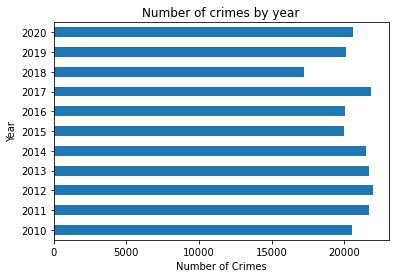

In [7]:
incidents.groupby([incidents.year]).size().plot(kind='barh')
plt.ylabel('Year')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by year')
plt.show()

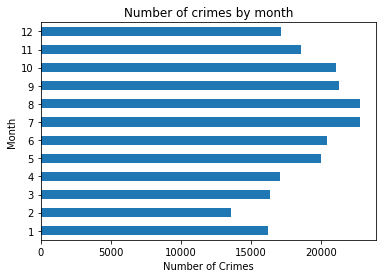

In [8]:
incidents.groupby([incidents.month]).size().plot(kind='barh')
plt.ylabel('Month')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by month')
plt.show()

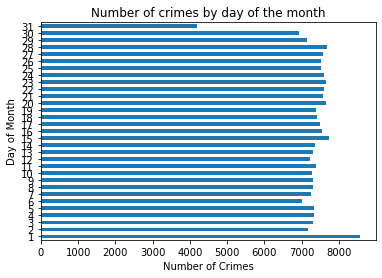

In [9]:
incidents.groupby([incidents.dayOfMonth]).size().plot(kind='barh')
plt.ylabel('Day of Month')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by day of the month')
plt.show()

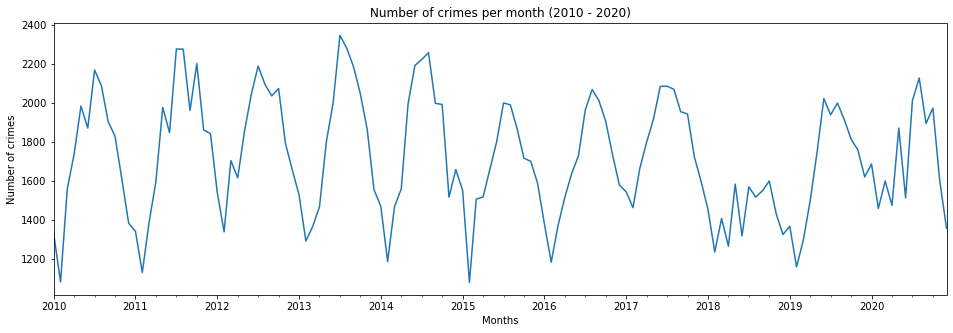

In [10]:
plt.figure(figsize=(16,5))
incidents.resample('M').size().plot(legend=False)
plt.title('Number of crimes per month (2010 - 2020)')
plt.xlabel('Months')
plt.ylabel('Number of crimes')
plt.show()

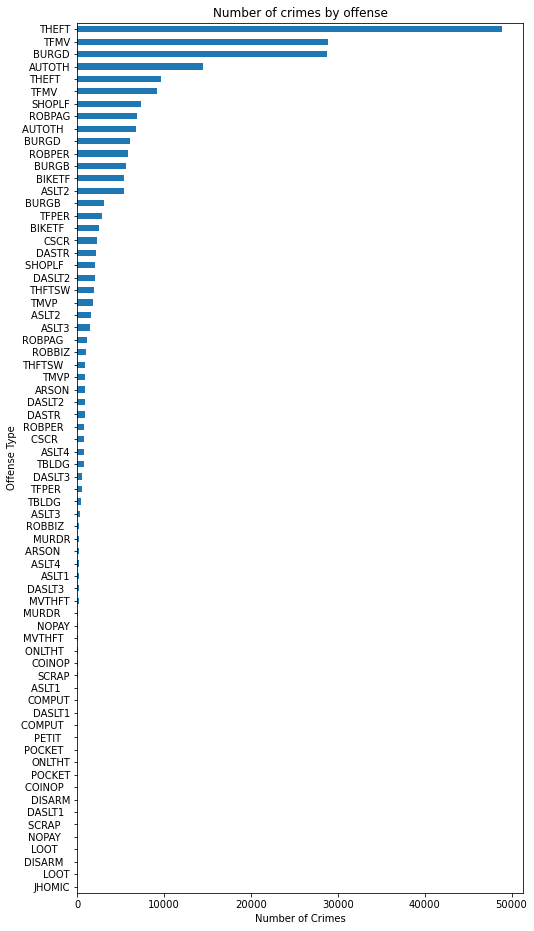

In [11]:
offense_grp = incidents.groupby([incidents.offense]).size().sort_values(ascending=True)

plt.figure(figsize=(8,16))
offense_grp.plot(kind='barh')
plt.ylabel('Offense Type')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by offense')
plt.show()

In [12]:
incidents['offense'].value_counts(normalize=True)

THEFT       0.215292
TFMV        0.127198
BURGD       0.126587
AUTOTH      0.063747
THEFT       0.042647
              ...   
NOPAY       0.000013
LOOT        0.000013
JHOMIC      0.000004
LOOT        0.000004
DISARM      0.000004
Name: offense, Length: 70, dtype: float64

In [13]:
top25_offenses = list(incidents.groupby([incidents['offense']]).size().sort_values(ascending=True)[-25:].index)
top25_offenses

['ASLT3',
 'ASLT2   ',
 'TMVP    ',
 'THFTSW',
 'DASLT2',
 'SHOPLF  ',
 'DASTR',
 'CSCR',
 'BIKETF  ',
 'TFPER',
 'BURGB   ',
 'ASLT2',
 'BIKETF',
 'BURGB',
 'ROBPER',
 'BURGD   ',
 'AUTOTH  ',
 'ROBPAG',
 'SHOPLF',
 'TFMV    ',
 'THEFT   ',
 'AUTOTH',
 'BURGD',
 'TFMV',
 'THEFT']

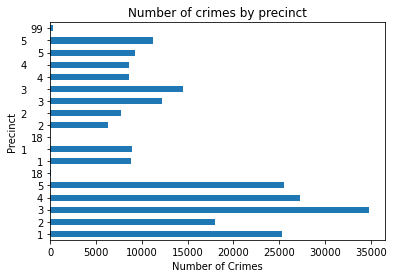

In [14]:
incidents.groupby([incidents.precinct]).size().plot(kind='barh')
plt.ylabel('Precinct')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by precinct')
plt.show()

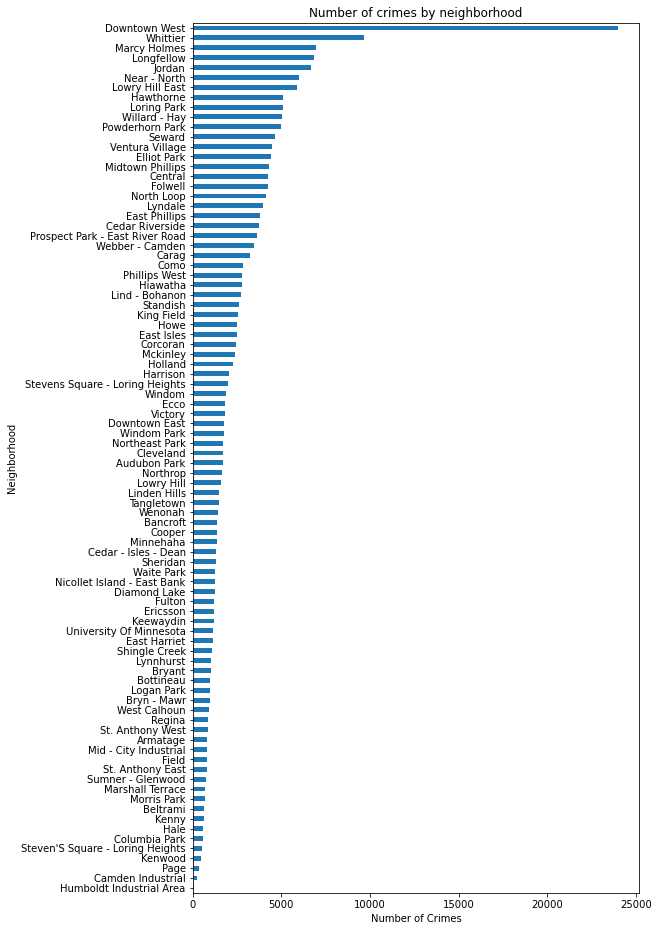

In [15]:
neighborhoods = incidents.groupby([incidents.neighborhood]).size().sort_values(ascending=True)

plt.figure(figsize=(8,16))
neighborhoods.plot(kind='barh')
plt.ylabel('Neighborhood')
plt.xlabel('Number of Crimes')
plt.title('Number of crimes by neighborhood')
plt.show()

In [16]:
fixed_lat = incidents.loc[incidents['lat']!=0]

C:\Users\gjete\Anaconda3\envs\PythonAdv\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 1.0, 'All Crime Distribution per neighborhood')

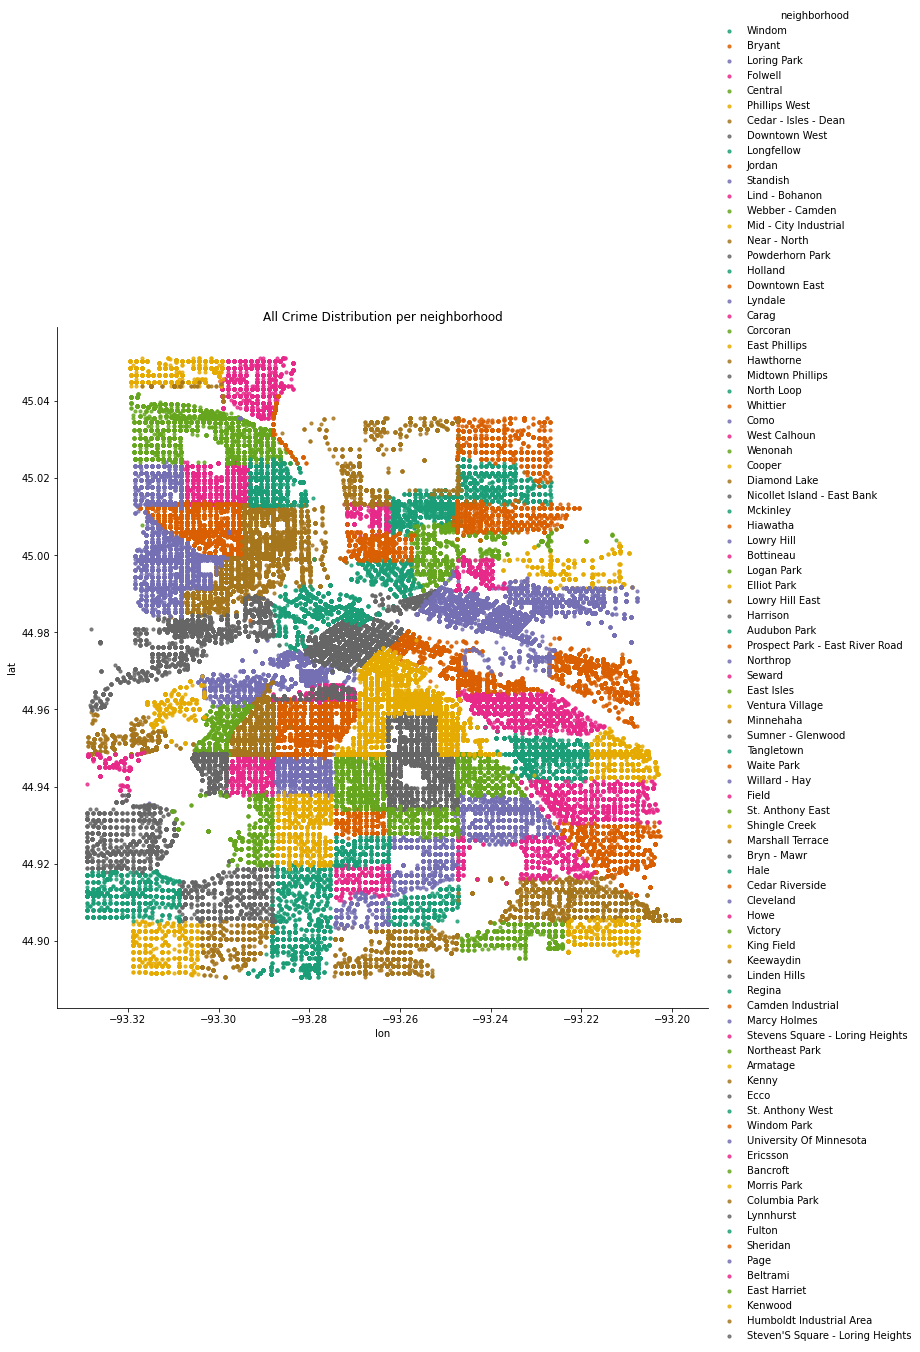

In [17]:
sns.lmplot('lon', 
           'lat',
           data=fixed_lat[:],
           fit_reg=False, 
           hue="neighborhood",
           palette='Dark2',
           height=10,
           ci=2,
           scatter_kws={"marker": "D", 
                        "s": 10})
ax = plt.gca()
ax.set_title("All Crime Distribution per neighborhood")

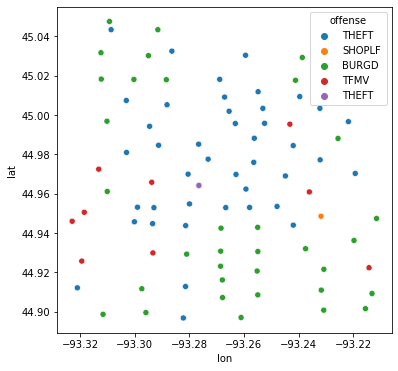

In [35]:
sdf = fixed_lat.groupby(['neighborhood', 'offense']).size().reset_index(name='counts')
idx = sdf.groupby(['neighborhood'])['counts'].transform(max) == sdf['counts']
sdf = sdf[idx]
other = fixed_lat.groupby('neighborhood')[['lon', 'lat']].mean()

# print(sdf, other)

fig, ax = plt.subplots(figsize=(6,6))


sdf = sdf.set_index('neighborhood').join(other)
sdf = sdf.reset_index().sort_values("counts",ascending=False)
a = sns.scatterplot(ax=ax, x='lon', y='lat', hue='offense', data=sdf)

# sns.lmplot(x='lon', y='lat',height=10, hue='offense', data=sdf, scatter_kws={"s": sdf['counts'].apply(lambda x: x/100.0)}, fit_reg=False)

# for r in sdf.reset_index().as_matrix():

#     neighborhood = "Neighborhood {0}, Count : {1}".format(int(r[1]),int(r[3]))
#     x = r[4]
#     y = r[5]
#     plt.annotate(
#         neighborhood,
#         xy=(x, y), xytext=(-20, 20),
#         textcoords='offset points', ha='right', va='bottom',
#         bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
#         arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))

In [34]:
# Identify Data to cluster

# incidents_c = pd.read_csv("../incident_data/yearly_incident_data/all_incidents.csv")
# incidents_c = incidents.dropna()
# incidents_c.head()

# cluster_data = incidents_c.drop(['publicAddress', 'caseNumber', 'precinct', 'description', 'ucrCode', 'neighborhood', 'incidentDate', 'incidentTime'], axis=1)

# #['lat', 'lon','offense']
# cluster_data

cluster_data = incidents.drop(['publicAddress', 'caseNumber', 'precinct', 'description', 'ucrCode', 'neighborhood', 'incidentDate', 'incidentTime'], axis=1)
cluster_data



,offense,lat,lon,month,year,dayOfWeek,dayOfMonth,dayOfYear,weekOfMonth,weekOfYear
incidentDate,,,,,,,,,,
2010-01-01,CSCR,44.900291,-93.288239,1,2010,4,1,1,1,1
2010-01-01,ROBPAG,44.890636,-93.280041,1,2010,4,1,1,1,1
2010-01-01,BURGD,44.931448,-93.268841,1,2010,4,1,1,1,1
2010-01-01,ASLT2,44.970506,-93.277714,1,2010,4,1,1,1,1
2010-01-01,BURGD,45.017746,-93.306988,1,2010,4,1,1,1,1
...,...,...,...,...,...,...,...,...,...,...
2020-12-24,SHOPLF,44.975633,-93.272376,12,2020,3,24,359,4,52
2020-12-24,SHOPLF,44.975633,-93.272376,12,2020,3,24,359,4,52
2020-12-22,BIKETF,44.973658,-93.229494,12,2020,1,22,357,4,51
